# Model Testing Notebook - CKA Evaluation

This notebook evaluates quantized DeepLabV3 models by comparing original backbone features with quantized features using CKA (Centered Kernel Alignment) metric.

## Overview
- Load trained quantized models from `models/` folder
- Extract features from Oxford-IIIT-Pet dataset
- Compute CKA similarity between original and quantized features
- Extensible framework for other metrics (CCA, Geometric Score)


## 1. Setup and Imports


In [ ]:
# Install required libraries
%pip install torch-cka

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from pathlib import Path

# Progress bars
from tqdm.notebook import tqdm

# Scientific computing for advanced metrics
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import pdist, squareform

# Import quantization libraries
from vector_quantize_pytorch import VectorQuantize, FSQ, ResidualVQ, LFQ

# Import CKA
from torch_cka import CKA

# Device setup
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")
    
print(f"Device: {device}")

# Define paths
MODELS_DIR = "./models"
DATA_DIR = "./data"

print(f"Models directory: {MODELS_DIR}")
print(f"Data directory: {DATA_DIR}")


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Using NVIDIA GPU
Device: cuda
Models directory: ./models
Data directory: ./data


## 2. Model Architecture Components


In [2]:
class SegmentationEncoder:
    """
    Encoder с residual adapter (features + adapter(features))
    """
    def __init__(self, backbone, device, feature_dim=2048, add_adapter=True):
        self.backbone = backbone
        self.device = device
        self.add_adapter = add_adapter
        
        # Backbone frozen
        self.backbone.eval()
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Residual adapter
        if add_adapter:
            self.adapter = nn.Sequential(
                nn.Conv2d(feature_dim, feature_dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(feature_dim),
                nn.ReLU(),
                nn.Conv2d(feature_dim, feature_dim, kernel_size=1)
            ).to(device)
            
            # ВАЖНО: Последний слой инициализируем нулями
            # Так в начале: features + 0 = features (identity)
            nn.init.zeros_(self.adapter[3].weight)
            nn.init.zeros_(self.adapter[3].bias)
        else:
            self.adapter = None
        
    def encode(self, images):
        with torch.no_grad():
            features = self.backbone(images)['out']
        
        if self.adapter is not None:
            # RESIDUAL: добавляем, а не заменяем!
            features = features + self.adapter(features)
        
        return features
    
    def parameters(self):
        if self.adapter is not None:
            return self.adapter.parameters()
        return []


class SegmentationDecoder:
    """
    Decoder с residual adapter (latents + adapter(latents))
    """
    def __init__(self, classifier, device, feature_dim=2048, add_adapter=True):
        self.classifier = classifier
        self.device = device
        self.add_adapter = add_adapter
        
        # Classifier frozen
        self.classifier.eval()
        for param in self.classifier.parameters():
            param.requires_grad = False
        
        # Residual adapter
        if add_adapter:
            self.adapter = nn.Sequential(
                nn.Conv2d(feature_dim, feature_dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(feature_dim),
                nn.ReLU(),
                nn.Conv2d(feature_dim, feature_dim, kernel_size=1)
            ).to(device)
            
            # ВАЖНО: Последний слой инициализируем нулями
            nn.init.zeros_(self.adapter[3].weight)
            nn.init.zeros_(self.adapter[3].bias)
        else:
            self.adapter = None
        
    def decode(self, latents, target_size):
        if self.adapter is not None:
            # RESIDUAL: добавляем, а не заменяем!
            latents = latents + self.adapter(latents)
        
        with torch.no_grad():
            output = self.classifier(latents)
            return F.interpolate(output, size=target_size, mode='bilinear')
    
    def parameters(self):
        if self.adapter is not None:
            return self.adapter.parameters()
        return []


In [3]:
class QuantizerWrapper:
    """
    Универсальная обертка для ВСЕХ quantizers (включая все WithProjection).
    """
    def __init__(self, quantizer, name="Quantizer"):
        self.quantizer = quantizer
        self.name = name
        
    def quantize_spatial(self, features):
        """Квантизует пространственные признаки [B, C, H, W]"""
        B, C, H, W = features.shape
        feat_seq = features.permute(0, 2, 3, 1).reshape(B, H * W, C)
        
        # FSQ и FSQWithProjection
        if isinstance(self.quantizer, FSQ) or hasattr(self.quantizer, 'fsq'):
            quant_seq, indices = self.quantizer(feat_seq)
            loss = torch.tensor(0.0, device=features.device)
            
        # LFQ и LFQWithProjection
        elif isinstance(self.quantizer, LFQ) or hasattr(self.quantizer, 'lfq'):
            quant_seq, indices, loss = self.quantizer(feat_seq)
            
        # VQ, ResidualVQ и их WithProjection версии
        elif isinstance(self.quantizer, (VectorQuantize, ResidualVQ)) or hasattr(self.quantizer, 'residual_vq'):
            quant_seq, indices, loss = self.quantizer(feat_seq)
            
        else:
            raise ValueError(f"Unknown quantizer type: {type(self.quantizer)}")
        
        quantized = quant_seq.reshape(B, H, W, C).permute(0, 3, 1, 2)
        
        if loss.numel() > 1:
            loss = loss.float().mean()
        
        return quantized, loss
    
    def __repr__(self):
        return f"{self.name}({self.quantizer})"


In [4]:
# Quantizer classes with projection layers (copied from original notebook)

class FSQWithProjection(nn.Module):
    """
    FSQ требует обучаемого encoder/decoder.
    С frozen backbone добавляем projection layers.
    """
    def __init__(self, input_dim, levels, device):
        super().__init__()
        self.num_levels = len(levels)
        # Project от input_dim к num_levels
        self.project_in = nn.Linear(input_dim, self.num_levels).to(device)
        self.fsq = FSQ(levels=levels, dim=self.num_levels).to(device)
        # Project обратно к input_dim
        self.project_out = nn.Linear(self.num_levels, input_dim).to(device)
    
    def forward(self, x):
        # x: [B, N, input_dim]
        x_proj = self.project_in(x)  # [B, N, num_levels]
        quantized, indices = self.fsq(x_proj)  # FSQ
        x_out = self.project_out(quantized)  # [B, N, input_dim]
        return x_out, indices
    
    def parameters(self):
        return list(self.project_in.parameters()) + list(self.project_out.parameters())


class ResidualVQWithProjection(nn.Module):
    """
    ResidualVQ в 2048D = 4×256×2048 = огромный codebook!
    Решение: Project к низкой размерности: 2048 → 64D → 2048
    """
    def __init__(self, input_dim, num_quantizers, codebook_size, decay, commitment_weight, device):
        super().__init__()
        # Уменьшаем размерность для компактного codebook
        self.bottleneck_dim = 64
        
        self.project_in = nn.Linear(input_dim, self.bottleneck_dim).to(device)
        
        self.residual_vq = ResidualVQ(
            dim=self.bottleneck_dim,  # Работаем в 64D!
            num_quantizers=num_quantizers,
            codebook_size=codebook_size,
            decay=decay,
            commitment_weight=commitment_weight
        ).to(device)
        
        self.project_out = nn.Linear(self.bottleneck_dim, input_dim).to(device)
    
    def forward(self, x):
        # x: [B, N, input_dim]
        x_proj = self.project_in(x)  # [B, N, 64]
        quantized, indices, loss = self.residual_vq(x_proj)
        x_out = self.project_out(quantized)  # [B, N, input_dim]
        return x_out, indices, loss
    
    def parameters(self):
        return list(self.project_in.parameters()) + list(self.residual_vq.parameters()) + list(self.project_out.parameters())


class LFQWithProjection(nn.Module):
    """
    LFQ требует низкоразмерного пространства (как в доке FashionMNIST).
    Project: 2048 → log2(512)=9D → 2048
    """
    def __init__(self, input_dim, codebook_size, entropy_loss_weight, diversity_gamma, spherical, device):
        super().__init__()
        import math
        # Как в доке: quantize_dim = log2(codebook_size)
        self.quantize_dim = int(math.log2(codebook_size))
        
        # Project к низкой размерности + нормализация
        self.project_in = nn.Sequential(
            nn.Linear(input_dim, self.quantize_dim),
            nn.LayerNorm(self.quantize_dim)
        ).to(device)
        
        # LFQ в низкой размерности
        self.lfq = LFQ(
            dim=self.quantize_dim,
            codebook_size=codebook_size,
            entropy_loss_weight=entropy_loss_weight,
            diversity_gamma=diversity_gamma,
            spherical=spherical
        ).to(device)
        
        # Project обратно
        self.project_out = nn.Linear(self.quantize_dim, input_dim).to(device)
    
    def forward(self, x):
        # x: [B, N, input_dim]
        x_proj = self.project_in(x)  # [B, N, quantize_dim]
        quantized, indices, entropy_loss = self.lfq(x_proj)
        x_out = self.project_out(quantized)  # [B, N, input_dim]
        return x_out, indices, entropy_loss
    
    def parameters(self):
        return list(self.project_in.parameters()) + list(self.lfq.parameters()) + list(self.project_out.parameters())


## 3. Model Loading Function


In [5]:
def load_model_from_checkpoint(model_path, device):
    """
    Load a complete model from saved checkpoint
    
    Args:
        model_path: Path to .pth file
        device: torch.device
    
    Returns:
        encoder, decoder, quantizer_wrapper, model_info
    """
    print(f"Loading model from: {model_path}")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create base DeepLabV3 model
    weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
    seg_model = deeplabv3_resnet50(weights=weights).to(device)
    
    # Load backbone and classifier state dicts
    if 'backbone_state_dict' in checkpoint:
        seg_model.backbone.load_state_dict(checkpoint['backbone_state_dict'])
    if 'classifier_state_dict' in checkpoint:
        seg_model.classifier.load_state_dict(checkpoint['classifier_state_dict'])
    
    # Create encoder and decoder
    encoder = SegmentationEncoder(
        seg_model.backbone, 
        device, 
        feature_dim=2048, 
        add_adapter=checkpoint.get('has_encoder_adapter', True)
    )
    
    decoder = SegmentationDecoder(
        seg_model.classifier, 
        device, 
        feature_dim=2048, 
        add_adapter=checkpoint.get('has_decoder_adapter', True)
    )
    
    # Load adapter weights if available
    if checkpoint.get('encoder_adapter_state_dict') is not None and encoder.adapter is not None:
        encoder.adapter.load_state_dict(checkpoint['encoder_adapter_state_dict'])
        print("✓ Loaded encoder adapter weights")
    
    if checkpoint.get('decoder_adapter_state_dict') is not None and decoder.adapter is not None:
        decoder.adapter.load_state_dict(checkpoint['decoder_adapter_state_dict'])
        print("✓ Loaded decoder adapter weights")
    
    # Create quantizer based on method
    method = checkpoint.get('method', 'Unknown')
    quantizer_wrapper = None
    
    if method == 'VQ-EMA':
        quantizer = VectorQuantize(
            dim=2048,
            codebook_size=512,
            decay=0.8,
            commitment_weight=1.0,
            threshold_ema_dead_code=2
        ).to(device)
        
        if checkpoint.get('quantizer_state_dict') is not None:
            quantizer.load_state_dict(checkpoint['quantizer_state_dict'])
        
        quantizer_wrapper = QuantizerWrapper(quantizer, "VQ-EMA")
        
    elif method == 'FSQ':
        quantizer = FSQWithProjection(
            input_dim=2048,
            levels=[8, 5, 5, 5],
            device=device
        )
        
        if checkpoint.get('quantizer_state_dict') is not None:
            quantizer.load_state_dict(checkpoint['quantizer_state_dict'])
        
        quantizer_wrapper = QuantizerWrapper(quantizer, "FSQ")
        
    elif method == 'LFQ':
        quantizer = LFQWithProjection(
            input_dim=2048,
            codebook_size=512,
            entropy_loss_weight=0.02,
            diversity_gamma=1.0,
            spherical=True,
            device=device
        )
        
        if checkpoint.get('quantizer_state_dict') is not None:
            quantizer.load_state_dict(checkpoint['quantizer_state_dict'])
        
        quantizer_wrapper = QuantizerWrapper(quantizer, "LFQ")
        
    elif method == 'ResidualVQ':
        # Detect whether the saved quantizer used projection layers
        q_sd = checkpoint.get('quantizer_state_dict') or {}
        q_keys = list(q_sd.keys())
        uses_projection = any(k.startswith('project_in') or k.startswith('residual_vq.') for k in q_keys)
        plain_layout = any(k.startswith('layers.') for k in q_keys)

        if uses_projection and not plain_layout:
            # Saved as ResidualVQWithProjection
            quantizer = ResidualVQWithProjection(
                input_dim=2048,
                num_quantizers=4,
                codebook_size=256,
                decay=0.8,
                commitment_weight=1.0,
                device=device
            )
        else:
            # Saved as plain ResidualVQ (no projection)
            quantizer = ResidualVQ(
                dim=2048,
                num_quantizers=4,
                codebook_size=256,
                decay=0.8,
                commitment_weight=1.0
            ).to(device)

        if q_sd:
            missing_ok = not uses_projection  # be strict when shapes match
            quantizer.load_state_dict(q_sd, strict=uses_projection)
        
        quantizer_wrapper = QuantizerWrapper(quantizer, "ResidualVQ")
    
    if quantizer_wrapper is None:
        raise ValueError(f"Unknown method: {method}")
    
    print(f"✓ Successfully loaded {method} model")
    
    return encoder, decoder, quantizer_wrapper, checkpoint


def load_original_model(device):
    """
    Load original DeepLabV3 model without quantization
    """
    print("Loading original DeepLabV3 model...")
    
    weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
    seg_model = deeplabv3_resnet50(weights=weights).to(device)
    
    # Create encoder and decoder WITHOUT adapters for original model
    encoder = SegmentationEncoder(seg_model.backbone, device, add_adapter=False)
    decoder = SegmentationDecoder(seg_model.classifier, device, add_adapter=False)
    
    print("✓ Loaded original DeepLabV3 model")
    
    return encoder, decoder


## 4. Dataset Preparation


In [6]:
# Dataset transforms (same as training)
transform_image = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.CenterCrop(256),
    transforms.PILToTensor()
])

class PetDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, pet_dataset, transform_image, transform_mask):
        self.dataset = pet_dataset
        self.transform_image = transform_image
        self.transform_mask = transform_mask
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, mask = self.dataset[idx]
        return self.transform_image(image), self.transform_mask(mask)

# Load Oxford-IIIT-Pet dataset (robust download/validation)
pet_root = DATA_DIR
pet_dir = os.path.join(pet_root, 'oxford-iiit-pet')
images_dir = os.path.join(pet_dir, 'images')
trimaps_dir = os.path.join(pet_dir, 'annotations', 'trimaps')

need_download = not (os.path.isdir(images_dir) and os.path.isdir(trimaps_dir))
if need_download:
    print("Dataset or annotations not found. Downloading...")

pet_dataset = OxfordIIITPet(
    root=pet_root,
    split='trainval',
    target_types='segmentation',
    download=need_download
)

# Validate sample access; if it fails, force re-download
try:
    _ = pet_dataset[0]
except FileNotFoundError:
    print("Detected missing files in dataset. Re-downloading annotations/images...")
    pet_dataset = OxfordIIITPet(
        root=pet_root,
        split='trainval',
        target_types='segmentation',
        download=True
    )

wrapped = PetDatasetWrapper(pet_dataset, transform_image, transform_mask)

# Use full training part (all images)
test_subset = wrapped
test_loader = DataLoader(test_subset, batch_size=8, shuffle=False, num_workers=0)

print(f"Train dataset ready: {len(test_subset)} images, {len(test_loader)} batches")
print(f"Batch size: {test_loader.batch_size}")


Train dataset ready: 3680 images, 460 batches
Batch size: 8


## 5. Extensible Metric Framework


## 5. Helper Functions for Advanced Metrics


In [7]:
def compute_cca_svd(X, Y, epsilon=1e-6):
    """
    Compute CCA using SVD (numerically stable).
    
    Args:
        X: [N, D1] features
        Y: [N, D2] features
        epsilon: regularization for numerical stability
    
    Returns:
        canonical_correlations: torch.Tensor of correlations
        U, V: canonical variables
    """
    # Center
    X = X - X.mean(dim=0, keepdim=True)
    Y = Y - Y.mean(dim=0, keepdim=True)
    
    # Covariance matrices
    N = X.size(0)
    Cxx = (X.t() @ X) / (N - 1) + epsilon * torch.eye(X.size(1), device=X.device)
    Cyy = (Y.t() @ Y) / (N - 1) + epsilon * torch.eye(Y.size(1), device=Y.device)
    Cxy = (X.t() @ Y) / (N - 1)
    
    # Cholesky decomposition
    try:
        Lx = torch.linalg.cholesky(Cxx)
        Ly = torch.linalg.cholesky(Cyy)
    except:
        # Fallback to eigendecomposition if Cholesky fails
        Lx = torch.linalg.cholesky(Cxx + epsilon * 10 * torch.eye(Cxx.size(0), device=X.device))
        Ly = torch.linalg.cholesky(Cyy + epsilon * 10 * torch.eye(Cyy.size(0), device=Y.device))
    
    # Solve for whitened cross-covariance
    Lx_inv = torch.linalg.inv(Lx)
    Ly_inv = torch.linalg.inv(Ly)
    T = Lx_inv @ Cxy @ Ly_inv.t()
    
    # SVD
    U, S, Vt = torch.linalg.svd(T, full_matrices=False)
    
    # Canonical correlations are singular values
    return S.clamp(0.0, 1.0), U, Vt.t()


def compute_pairwise_distances(X, metric='euclidean', max_samples=2000):
    """
    Compute pairwise distances, optionally sampling for memory efficiency.
    
    Args:
        X: [N, D] features
        metric: distance metric
        max_samples: if N > max_samples, randomly sample
    
    Returns:
        distances: flattened distance vector
    """
    X_np = X.cpu().numpy()
    
    if X_np.shape[0] > max_samples:
        indices = np.random.choice(X_np.shape[0], max_samples, replace=False)
        X_np = X_np[indices]
    
    # Compute pairwise distances (returns condensed form)
    distances = pdist(X_np, metric=metric)
    return distances


def compute_knn_indices(X, k=10, device=None):
    """
    Compute k-nearest neighbors for each sample.
    
    Args:
        X: [N, D] features (torch tensor)
        k: number of neighbors
        device: computation device
    
    Returns:
        knn_indices: [N, k] tensor of neighbor indices
    """
    if device is None:
        device = X.device
    
    X = X.to(device)
    
    # Compute pairwise distances using batched approach for memory efficiency
    N = X.size(0)
    knn_indices = torch.zeros(N, k, dtype=torch.long, device='cpu')
    
    batch_size = min(500, N)
    for i in range(0, N, batch_size):
        end_i = min(i + batch_size, N)
        X_batch = X[i:end_i]
        
        # Compute distances from batch to all points
        dists = torch.cdist(X_batch, X, p=2)  # [batch_size, N]
        
        # Get k+1 nearest (including self), then exclude self
        _, indices = torch.topk(dists, k + 1, largest=False, dim=1)
        
        # Remove self (first element is always self with distance 0)
        knn_batch = indices[:, 1:k+1].cpu()
        knn_indices[i:end_i] = knn_batch
    
    return knn_indices


def jaccard_similarity(set1, set2):
    """Compute Jaccard similarity between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0.0


In [9]:
class SimilarityMetric:
    """
    Abstract base class for similarity metrics
    """
    def compute(self, features_1, features_2):
        """
        Compute similarity between two feature representations
        
        Args:
            features_1: First feature tensor [N, D] or [B, C, H, W]
            features_2: Second feature tensor [N, D] or [B, C, H, W]
        
        Returns:
            similarity_score: float between 0 and 1
        """
        raise NotImplementedError


class CKAMetric(SimilarityMetric):
    """
    Centered Kernel Alignment (CKA) metric implementation (linear CKA).
    Memory-efficient: pools spatial dims to [N, C] and uses N×N Gram matrices.
    """
    def __init__(self, device=None):
        self.device = device or torch.device('cpu')
    
    @staticmethod
    def _center_gram(K: torch.Tensor) -> torch.Tensor:
        """Center an N×N Gram matrix."""
        mean_row = K.mean(dim=0, keepdim=True)
        mean_col = K.mean(dim=1, keepdim=True)
        mean_total = K.mean()
        return K - mean_row - mean_col + mean_total
    
    @staticmethod
    def _gram_linear(X: torch.Tensor) -> torch.Tensor:
        """Compute linear kernel Gram matrix K = X X^T (N×N)."""
        return X @ X.t()
    
    def compute(self, features_1, features_2):
        """
        Compute linear CKA similarity between two feature sets.
        
        Args:
            features_1: [N, D] or [N, C, H, W]
            features_2: [N, D] or [N, C, H, W]
        Returns:
            float in [0, 1]
        """
        # Spatial pooling BEFORE GPU transfer (defensive, memory-efficient)
        if features_1.dim() == 4:  # [N, C, H, W]
            features_1 = features_1.mean(dim=(2, 3))  # [N, C]
        if features_2.dim() == 4:
            features_2 = features_2.mean(dim=(2, 3))
        
        X = features_1.to(self.device)
        Y = features_2.to(self.device)
        
        # Center features (per-dimension)
        X = X - X.mean(dim=0, keepdim=True)
        Y = Y - Y.mean(dim=0, keepdim=True)
        
        # Gram matrices (N×N), then center in RKHS
        K = self._center_gram(self._gram_linear(X))
        L = self._center_gram(self._gram_linear(Y))
        
        # HSIC and normalization
        hsic = (K * L).sum()
        norm_x = (K * K).sum().clamp_min(1e-12).sqrt()
        norm_y = (L * L).sum().clamp_min(1e-12).sqrt()
        cka = (hsic / (norm_x * norm_y)).clamp(0.0, 1.0)
        return float(cka.item())


class CCAMetric(SimilarityMetric):
    """
    Canonical Correlation Analysis (CCA) metric - placeholder for future implementation
    """
    def __init__(self, device=None):
        self.device = device or torch.device('cpu')
        print("CCA metric - placeholder implementation")
    
    def compute(self, features_1, features_2):
        """
        Placeholder CCA implementation
        """
        # TODO: Implement CCA
        return 0.0


class GeometricScoreMetric(SimilarityMetric):
    """
    Geometric Score metric - placeholder for future implementation
    """
    def __init__(self, device=None):
        self.device = device or torch.device('cpu')
        print("Geometric Score metric - placeholder implementation")
    
    def compute(self, features_1, features_2):
        """
        Placeholder Geometric Score implementation
        """
        # TODO: Implement Geometric Score
        return 0.0


In [11]:
class PWCCAMetric(SimilarityMetric):
    """
    Projection Weighted Canonical Correlation Analysis (PWCCA).
    Weights canonical correlations by variance explained.
    """
    def __init__(self, device=None):
        self.device = device or torch.device('cpu')
    
    def compute(self, features_1, features_2):
        """
        Compute PWCCA score.
        
        Args:
            features_1: [N, D] or [N, C, H, W]
            features_2: [N, D] or [N, C, H, W]
        
        Returns:
            pwcca_score: float in [0, 1]
        """
        X = features_1.to(self.device)
        Y = features_2.to(self.device)
        
        # Pool spatial dimensions if needed
        if X.dim() == 4:
            X = X.mean(dim=(2, 3))
        if Y.dim() == 4:
            Y = Y.mean(dim=(2, 3))
        
        # Compute CCA
        canonical_corrs, U, V = compute_cca_svd(X, Y)
        
        # Project onto canonical variables
        X_proj = X @ U
        Y_proj = Y @ V
        
        # Compute variance explained by each canonical variable
        var_X = X_proj.var(dim=0)
        var_Y = Y_proj.var(dim=0)
        
        # Weight by minimum variance (more conservative)
        weights = torch.minimum(var_X, var_Y)
        weights = weights / weights.sum()  # normalize
        
        # Weighted average of canonical correlations
        pwcca = (canonical_corrs * weights).sum()
        
        return float(pwcca.item())


class GeometryScoreMetric(SimilarityMetric):
    """
    Geometry Score: measures preservation of pairwise distances.
    Uses Spearman correlation between distance matrices.
    """
    def __init__(self, device=None, max_samples=2000):
        self.device = device or torch.device('cpu')
        self.max_samples = max_samples
    
    def compute(self, features_1, features_2):
        """
        Compute Geometry Score.
        
        Args:
            features_1: [N, D] or [N, C, H, W]
            features_2: [N, D] or [N, C, H, W]
        
        Returns:
            geometry_score: float, Spearman correlation of distances
        """
        X = features_1
        Y = features_2
        
        # Pool spatial dimensions
        if X.dim() == 4:
            X = X.mean(dim=(2, 3))
        if Y.dim() == 4:
            Y = Y.mean(dim=(2, 3))
        
        # Compute pairwise distances
        dist_X = compute_pairwise_distances(X, max_samples=self.max_samples)
        dist_Y = compute_pairwise_distances(Y, max_samples=self.max_samples)
        
        # Spearman correlation
        corr, _ = spearmanr(dist_X, dist_Y)
        
        return float(corr) if not np.isnan(corr) else 0.0


class RSAMetric(SimilarityMetric):
    """
    Representational Similarity Analysis (RSA).
    Compares representational dissimilarity matrices using Pearson correlation.
    """
    def __init__(self, device=None, max_samples=2000):
        self.device = device or torch.device('cpu')
        self.max_samples = max_samples
    
    def compute(self, features_1, features_2):
        """
        Compute RSA score.
        
        Args:
            features_1: [N, D] or [N, C, H, W]
            features_2: [N, D] or [N, C, H, W]
        
        Returns:
            rsa_score: float, Pearson correlation of RDMs
        """
        X = features_1.to(self.device)
        Y = features_2.to(self.device)
        
        # Pool spatial dimensions
        if X.dim() == 4:
            X = X.mean(dim=(2, 3))
        if Y.dim() == 4:
            Y = Y.mean(dim=(2, 3))
        
        # Sample if too large
        if X.size(0) > self.max_samples:
            indices = torch.randperm(X.size(0))[:self.max_samples]
            X = X[indices]
            Y = Y[indices]
        
        # Normalize features
        X = F.normalize(X, p=2, dim=1)
        Y = F.normalize(Y, p=2, dim=1)
        
        # Compute RDM (1 - cosine similarity)
        rdm_X = 1 - (X @ X.t()).cpu().numpy()
        rdm_Y = 1 - (Y @ Y.t()).cpu().numpy()
        
        # Extract upper triangular (excluding diagonal)
        mask = np.triu(np.ones_like(rdm_X), k=1).astype(bool)
        rdm_X_vec = rdm_X[mask]
        rdm_Y_vec = rdm_Y[mask]
        
        # Pearson correlation
        corr, _ = pearsonr(rdm_X_vec, rdm_Y_vec)
        
        return float(corr) if not np.isnan(corr) else 0.0


class RelationalKnowledgeLossMetric(SimilarityMetric):
    """
    Relational Knowledge Loss: measures how well k-NN relationships are preserved.
    Returns a LOSS value (lower is better).
    """
    def __init__(self, device=None, k=10):
        self.device = device or torch.device('cpu')
        self.k = k
    
    def compute(self, features_1, features_2):
        """
        Compute relational knowledge loss.
        
        Args:
            features_1: [N, D] or [N, C, H, W]
            features_2: [N, D] or [N, C, H, W]
        
        Returns:
            loss: float in [0, 1], lower is better
        """
        X = features_1.to(self.device)
        Y = features_2.to(self.device)
        
        # Pool spatial dimensions
        if X.dim() == 4:
            X = X.mean(dim=(2, 3))
        if Y.dim() == 4:
            Y = Y.mean(dim=(2, 3))
        
        # Compute k-NN for both
        knn_X = compute_knn_indices(X, k=self.k, device=self.device)
        knn_Y = compute_knn_indices(Y, k=self.k, device=self.device)
        
        # For each sample, check how many of its k-NN in X are also in top-k in Y
        N = X.size(0)
        overlaps = []
        
        for i in range(N):
            neighbors_X = set(knn_X[i].tolist())
            neighbors_Y = set(knn_Y[i].tolist())
            overlap = len(neighbors_X.intersection(neighbors_Y))
            overlaps.append(overlap / self.k)
        
        # Average overlap
        avg_overlap = np.mean(overlaps)
        
        # Return as loss (1 - overlap)
        loss = 1.0 - avg_overlap
        
        return float(loss)


class JaccardKNNMetric(SimilarityMetric):
    """
    Jaccard KNN: Jaccard similarity of k-nearest neighbor sets.
    """
    def __init__(self, device=None, k=10):
        self.device = device or torch.device('cpu')
        self.k = k
    
    def compute(self, features_1, features_2):
        """
        Compute average Jaccard similarity of k-NN sets.
        
        Args:
            features_1: [N, D] or [N, C, H, W]
            features_2: [N, D] or [N, C, H, W]
        
        Returns:
            jaccard_score: float in [0, 1]
        """
        X = features_1.to(self.device)
        Y = features_2.to(self.device)
        
        # Pool spatial dimensions
        if X.dim() == 4:
            X = X.mean(dim=(2, 3))
        if Y.dim() == 4:
            Y = Y.mean(dim=(2, 3))
        
        # Compute k-NN for both
        knn_X = compute_knn_indices(X, k=self.k, device=self.device)
        knn_Y = compute_knn_indices(Y, k=self.k, device=self.device)
        
        # Compute Jaccard for each sample
        N = X.size(0)
        jaccard_scores = []
        
        for i in range(N):
            neighbors_X = set(knn_X[i].tolist())
            neighbors_Y = set(knn_Y[i].tolist())
            jaccard = jaccard_similarity(neighbors_X, neighbors_Y)
            jaccard_scores.append(jaccard)
        
        # Average Jaccard
        avg_jaccard = np.mean(jaccard_scores)
        
        return float(avg_jaccard)


In [12]:
# ============================================================================
# DEFENSIVE POOLING UPDATES FOR METRICS
# ============================================================================
# Update metric classes to pool BEFORE .to(device) for memory safety
# This prevents OOM when features are accidentally passed as [N, C, H, W]
# ============================================================================

# Monkey-patch existing metric compute methods with defensive pooling

def _defensive_pwcca_compute(self, features_1, features_2):
    """PWCCA with defensive pooling before GPU transfer"""
    # Pool BEFORE .to(device)
    if features_1.dim() == 4:
        features_1 = features_1.mean(dim=(2, 3))
    if features_2.dim() == 4:
        features_2 = features_2.mean(dim=(2, 3))
    
    X = features_1.to(self.device)
    Y = features_2.to(self.device)
    
    # Compute CCA
    canonical_corrs, U, V = compute_cca_svd(X, Y)
    
    # Project onto canonical variables
    X_proj = X @ U
    Y_proj = Y @ V
    
    # Compute variance explained
    var_X = X_proj.var(dim=0)
    var_Y = Y_proj.var(dim=0)
    
    # Weight by minimum variance
    weights = torch.minimum(var_X, var_Y)
    weights = weights / weights.sum()
    
    # Weighted average
    pwcca = (canonical_corrs * weights).sum()
    return float(pwcca.item())

def _defensive_rsa_compute(self, features_1, features_2):
    """RSA with defensive pooling before GPU transfer"""
    # Pool BEFORE .to(device)
    if features_1.dim() == 4:
        features_1 = features_1.mean(dim=(2, 3))
    if features_2.dim() == 4:
        features_2 = features_2.mean(dim=(2, 3))
    
    X = features_1.to(self.device)
    Y = features_2.to(self.device)
    
    # Sample if too large
    if X.size(0) > self.max_samples:
        indices = torch.randperm(X.size(0))[:self.max_samples]
        X = X[indices]
        Y = Y[indices]
    
    # Compute RDMs (1 - cosine similarity)
    X_norm = torch.nn.functional.normalize(X, dim=1)
    Y_norm = torch.nn.functional.normalize(Y, dim=1)
    
    rdm_X = 1 - (X_norm @ X_norm.t())
    rdm_Y = 1 - (Y_norm @ Y_norm.t())
    
    # Flatten upper triangular (excluding diagonal)
    mask = torch.triu(torch.ones_like(rdm_X), diagonal=1).bool()
    rdm_X_flat = rdm_X[mask].cpu().numpy()
    rdm_Y_flat = rdm_Y[mask].cpu().numpy()
    
    # Pearson correlation
    corr, _ = pearsonr(rdm_X_flat, rdm_Y_flat)
    return float(corr)

def _defensive_relational_compute(self, features_1, features_2):
    """Relational Knowledge Loss with defensive pooling"""
    # Pool BEFORE .to(device)
    if features_1.dim() == 4:
        features_1 = features_1.mean(dim=(2, 3))
    if features_2.dim() == 4:
        features_2 = features_2.mean(dim=(2, 3))
    
    X = features_1.to(self.device)
    Y = features_2.to(self.device)
    
    # Compute k-NN
    knn_X = compute_knn_indices(X, k=self.k, device=self.device)
    knn_Y = compute_knn_indices(Y, k=self.k, device=self.device)
    
    # Compute loss
    N = X.size(0)
    total_lost = 0
    for i in range(N):
        neighbors_X = set(knn_X[i].tolist())
        neighbors_Y = set(knn_Y[i].tolist())
        lost = len(neighbors_X - neighbors_Y)
        total_lost += lost
    
    loss = total_lost / (N * self.k)
    return float(loss)

def _defensive_jaccard_compute(self, features_1, features_2):
    """Jaccard KNN with defensive pooling"""
    # Pool BEFORE .to(device)
    if features_1.dim() == 4:
        features_1 = features_1.mean(dim=(2, 3))
    if features_2.dim() == 4:
        features_2 = features_2.mean(dim=(2, 3))
    
    X = features_1.to(self.device)
    Y = features_2.to(self.device)
    
    # Compute k-NN
    knn_X = compute_knn_indices(X, k=self.k, device=self.device)
    knn_Y = compute_knn_indices(Y, k=self.k, device=self.device)
    
    # Compute Jaccard
    N = X.size(0)
    jaccard_scores = []
    for i in range(N):
        neighbors_X = set(knn_X[i].tolist())
        neighbors_Y = set(knn_Y[i].tolist())
        jaccard_scores.append(jaccard_similarity(neighbors_X, neighbors_Y))
    
    return float(np.mean(jaccard_scores))

# Apply monkey patches
PWCCAMetric.compute = _defensive_pwcca_compute
RSAMetric.compute = _defensive_rsa_compute
RelationalKnowledgeLossMetric.compute = _defensive_relational_compute
JaccardKNNMetric.compute = _defensive_jaccard_compute

print("✓ Applied defensive pooling to all metrics (OOM protection)")


✓ Applied defensive pooling to all metrics (OOM protection)


In [13]:
# Metric registry for easy switching
METRIC_REGISTRY = {
    'cka': CKAMetric,
    'pwcca': PWCCAMetric,
    'geometry': GeometryScoreMetric,
    'rsa': RSAMetric,
    'relational': RelationalKnowledgeLossMetric,
    'jaccard_knn': JaccardKNNMetric,
    'cca': CCAMetric  # kept for backward compatibility
}

def create_metric(metric_name, device=None):
    """
    Create a metric instance by name
    
    Args:
        metric_name: metric key from METRIC_REGISTRY
        device: torch.device
    
    Returns:
        SimilarityMetric instance
    """
    if metric_name not in METRIC_REGISTRY:
        raise ValueError(f"Unknown metric: {metric_name}. Available: {list(METRIC_REGISTRY.keys())}")
    
    return METRIC_REGISTRY[metric_name](device=device)

print("✓ Metric framework initialized")
print(f"Available metrics: {list(METRIC_REGISTRY.keys())}")

✓ Metric framework initialized
Available metrics: ['cka', 'pwcca', 'geometry', 'rsa', 'relational', 'jaccard_knn', 'cca']


## 6. Feature Extraction Functions


In [14]:
def _extract_pooled_backbone_features(encoder, images, device):
    with torch.no_grad():
        feats = encoder.backbone(images)['out']  # [B, C, H, W]
        pooled = feats.mean(dim=(2, 3))          # [B, C]
    return pooled


def _extract_pooled_quantized_features(encoder, quantizer_wrapper, decoder, images, device):
    with torch.no_grad():
        encoded = encoder.encode(images)                         # [B, C, H, W]
        quantized, _ = quantizer_wrapper.quantize_spatial(encoded)
        if decoder.adapter is not None:
            quantized = quantized + decoder.adapter(quantized)
        pooled = quantized.mean(dim=(2, 3))                     # [B, C]
    return pooled


def _compute_mean_over_loader(extractor_fn, loader, device, print_every=20):
    mean = None
    count = 0
    for batch_idx, (images, _) in enumerate(loader):
        if batch_idx % print_every == 0:
            print(f"  [Pass 1] Batch {batch_idx}/{len(loader)}")
        images = images.to(device, non_blocking=True)
        X = extractor_fn(images)
        if mean is None:
            mean = X.sum(dim=0)
        else:
            mean += X.sum(dim=0)
        count += X.size(0)
    mean = mean / max(count, 1)
    return mean, count


def compute_linear_cka_streaming(original_encoder, quantized_encoder, quantizer_wrapper, decoder, loader, device, print_every=20):
    """
    Two-pass streaming linear CKA using covariance matrices; avoids storing all features.
    """
    original_encoder.backbone.eval()
    quantized_encoder.backbone.eval()
    decoder.classifier.eval()

    # Define extractors bound with correct modules
    def ext_orig(imgs):
        return _extract_pooled_backbone_features(original_encoder, imgs, device)
    def ext_quant(imgs):
        return _extract_pooled_quantized_features(quantized_encoder, quantizer_wrapper, decoder, imgs, device)

    # Pass 1: means
    print("  Computing means (original)...")
    mean_X, N = _compute_mean_over_loader(ext_orig, loader, device, print_every)
    print("  Computing means (quantized)...")
    mean_Y, N2 = _compute_mean_over_loader(ext_quant, loader, device, print_every)

    # Safety if dataset is empty
    if N == 0 or N2 == 0:
        return 0.0

    # Pass 2: covariance accumulators
    print("  Accumulating covariances...")
    Cxx = None
    Cyy = None
    Cxy = None

    for batch_idx, (images, _) in enumerate(loader):
        if batch_idx % print_every == 0:
            print(f"  [Pass 2] Batch {batch_idx}/{len(loader)}")
        images = images.to(device, non_blocking=True)
        X = ext_orig(images) - mean_X
        Y = ext_quant(images) - mean_Y
        # [B, C] -> [C, C]
        Cxx_b = X.t() @ X
        Cyy_b = Y.t() @ Y
        Cxy_b = X.t() @ Y
        if Cxx is None:
            Cxx, Cyy, Cxy = Cxx_b, Cyy_b, Cxy_b
        else:
            Cxx += Cxx_b
            Cyy += Cyy_b
            Cxy += Cxy_b

    # Linear CKA from covariances
    num = torch.norm(Cxy, p='fro') ** 2
    den = torch.norm(Cxx, p='fro') * torch.norm(Cyy, p='fro')
    cka = (num / den.clamp_min(1e-12)).clamp(0.0, 1.0)
    return float(cka.item())


In [15]:
def extract_original_features(encoder, data_loader, device):
    """
    Extract features from original backbone (no quantization, no adapters)
    
    Args:
        encoder: SegmentationEncoder WITHOUT adapters
        data_loader: DataLoader
        device: torch.device
    
    Returns:
        features: torch.Tensor [N, C, H, W] - original backbone features
    """
    print("Extracting original backbone features...")
    
    all_features = []
    
    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(data_loader):
            if batch_idx % 10 == 0:
                print(f"  Processing batch {batch_idx}/{len(data_loader)}")
            
            images = images.to(device)
            
            # Extract features directly from backbone (no adapters)
            features = encoder.backbone(images)['out']
            all_features.append(features.cpu())
    
    # Concatenate all features
    features = torch.cat(all_features, dim=0)
    print(f"✓ Extracted original features: {features.shape}")
    
    return features


def extract_quantized_features(encoder, quantizer_wrapper, decoder, data_loader, device):
    """
    Extract features from quantized model (encoder → quantizer → decoder with adapters)
    
    Args:
        encoder: SegmentationEncoder WITH adapters
        quantizer_wrapper: QuantizerWrapper
        decoder: SegmentationDecoder WITH adapters
        data_loader: DataLoader
        device: torch.device
    
    Returns:
        features: torch.Tensor [N, C, H, W] - quantized features
    """
    print(f"Extracting quantized features from {quantizer_wrapper.name}...")
    
    all_features = []
    
    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(data_loader):
            if batch_idx % 10 == 0:
                print(f"  Processing batch {batch_idx}/{len(data_loader)}")
            
            images = images.to(device)
            
            # Extract features with encoder (with adapters)
            encoded_features = encoder.encode(images)
            
            # Quantize features
            quantized_features, _ = quantizer_wrapper.quantize_spatial(encoded_features)
            
            # Apply decoder adapter if available
            if decoder.adapter is not None:
                final_features = quantized_features + decoder.adapter(quantized_features)
            else:
                final_features = quantized_features
            
            all_features.append(final_features.cpu())
    
    # Concatenate all features
    features = torch.cat(all_features, dim=0)
    print(f"✓ Extracted quantized features: {features.shape}")
    
    return features


def extract_features_for_comparison(original_encoder, quantized_encoder, quantizer_wrapper, 
                                 quantized_decoder, data_loader, device):
    """
    Extract both original and quantized features for comparison
    
    Args:
        original_encoder: SegmentationEncoder WITHOUT adapters
        quantized_encoder: SegmentationEncoder WITH adapters
        quantizer_wrapper: QuantizerWrapper
        quantized_decoder: SegmentationDecoder WITH adapters
        data_loader: DataLoader
        device: torch.device
    
    Returns:
        original_features, quantized_features: torch.Tensor
    """
    print("Extracting features for comparison...")
    
    original_features = extract_original_features(original_encoder, data_loader, device)
    quantized_features = extract_quantized_features(
        quantized_encoder, quantizer_wrapper, quantized_decoder, data_loader, device
    )
    
    return original_features, quantized_features


In [16]:
# ============================================================================
# MEMORY-EFFICIENT POOLED FEATURE EXTRACTION
# ============================================================================
# These functions perform spatial pooling DURING extraction (not after),
# reducing memory from [N, C, H, W] (30 GB) to [N, C] (30 MB).
# All metrics already perform spatial pooling, so this doesn't change results.
# ============================================================================

def extract_original_features_pooled(encoder, data_loader, device):
    """
    Extract spatially-pooled features from original backbone (memory-efficient version).
    
    Performs spatial pooling on GPU before transferring to CPU, saving 1000× memory.
    
    Args:
        encoder: SegmentationEncoder WITHOUT adapters
        data_loader: DataLoader
        device: torch.device
    
    Returns:
        features: torch.Tensor [N, C] - spatially pooled backbone features
    """
    all_features = []
    
    with torch.no_grad():
        for images, _ in tqdm(data_loader, desc="Extracting original (pooled)", leave=False):
            images = images.to(device)
            
            # Extract features from backbone
            features = encoder.backbone(images)['out']  # [B, C, H, W]
            
            # ★ SPATIAL POOLING ON GPU (before CPU transfer)
            features_pooled = features.mean(dim=(2, 3))  # [B, C]
            
            all_features.append(features_pooled.cpu())
    
    # Concatenate all features
    features = torch.cat(all_features, dim=0)  # [N, C]
    
    return features


def extract_quantized_features_pooled(encoder, quantizer_wrapper, decoder, data_loader, device):
    """
    Extract spatially-pooled quantized features (memory-efficient version).
    
    Performs spatial pooling on GPU before transferring to CPU, saving 1000× memory.
    
    Args:
        encoder: SegmentationEncoder WITH adapters
        quantizer_wrapper: QuantizerWrapper
        decoder: SegmentationDecoder WITH adapters
        data_loader: DataLoader
        device: torch.device
    
    Returns:
        features: torch.Tensor [N, C] - spatially pooled quantized features
    """
    all_features = []
    
    with torch.no_grad():
        for images, _ in tqdm(data_loader, desc=f"Extracting {quantizer_wrapper.name} (pooled)", leave=False):
            images = images.to(device)
            
            # Extract features with encoder (with adapters)
            encoded_features = encoder.encode(images)
            
            # Quantize features
            quantized_features, _ = quantizer_wrapper.quantize_spatial(encoded_features)
            
            # Apply decoder adapter if available
            if decoder.adapter is not None:
                final_features = quantized_features + decoder.adapter(quantized_features)
            else:
                final_features = quantized_features
            
            # ★ SPATIAL POOLING ON GPU (before CPU transfer)
            final_features_pooled = final_features.mean(dim=(2, 3))  # [B, C]
            
            all_features.append(final_features_pooled.cpu())
    
    # Concatenate all features
    features = torch.cat(all_features, dim=0)  # [N, C]
    
    return features

print("✓ Memory-efficient pooled extraction functions loaded")


✓ Memory-efficient pooled extraction functions loaded


In [17]:
# ============================================================================
# IMPROVED STREAMING CKA WITH TQDM PROGRESS BARS
# ============================================================================

def _compute_mean_over_loader_tqdm(extractor_fn, loader, device, desc="Computing means"):
    """Compute mean features with tqdm progress bar"""
    mean = None
    count = 0
    for images, _ in tqdm(loader, desc=f"    {desc}", leave=False):
        images = images.to(device, non_blocking=True)
        X = extractor_fn(images)
        if mean is None:
            mean = X.sum(dim=0)
        else:
            mean += X.sum(dim=0)
        count += X.size(0)
    mean = mean / max(count, 1)
    return mean, count

def compute_linear_cka_streaming_tqdm(original_encoder, quantized_encoder, quantizer_wrapper, decoder, loader, device):
    """
    Two-pass streaming linear CKA using covariance matrices with tqdm progress bars
    """
    original_encoder.backbone.eval()
    quantized_encoder.backbone.eval()
    decoder.classifier.eval()

    # Define extractors
    def ext_orig(imgs):
        return _extract_pooled_backbone_features(original_encoder, imgs, device)
    def ext_quant(imgs):
        return _extract_pooled_quantized_features(quantized_encoder, quantizer_wrapper, decoder, imgs, device)

    # Pass 1: means
    mean_X, N = _compute_mean_over_loader_tqdm(ext_orig, loader, device, "Pass 1: Original")
    mean_Y, N2 = _compute_mean_over_loader_tqdm(ext_quant, loader, device, "Pass 1: Quantized")

    if N == 0 or N2 == 0:
        return 0.0

    # Pass 2: covariances
    Cxx = None
    Cyy = None
    Cxy = None

    for images, _ in tqdm(loader, desc="    Pass 2: Covariances", leave=False):
        images = images.to(device, non_blocking=True)
        X = ext_orig(images) - mean_X
        Y = ext_quant(images) - mean_Y
        
        Cxx_b = X.t() @ X
        Cyy_b = Y.t() @ Y
        Cxy_b = X.t() @ Y
        
        if Cxx is None:
            Cxx = Cxx_b
            Cyy = Cyy_b
            Cxy = Cxy_b
        else:
            Cxx += Cxx_b
            Cyy += Cyy_b
            Cxy += Cxy_b

    Cxx = Cxx / max(N - 1, 1)
    Cyy = Cyy / max(N2 - 1, 1)
    Cxy = Cxy / max(N - 1, 1)

    # HSIC computation
    hsic = torch.trace(Cxx @ Cyy.t()) + torch.trace(Cxx) * torch.trace(Cyy) - 2 * torch.trace(Cxy)
    norm_x = torch.sqrt(torch.trace(Cxx @ Cxx) + torch.trace(Cxx)**2)
    norm_y = torch.sqrt(torch.trace(Cyy @ Cyy) + torch.trace(Cyy)**2)
    
    cka = hsic / (norm_x * norm_y + 1e-12)
    return float(cka.clamp(0.0, 1.0).item())

# Update the function pointer
compute_linear_cka_streaming = compute_linear_cka_streaming_tqdm

print("✓ Streaming CKA updated with tqdm progress bars")


✓ Streaming CKA updated with tqdm progress bars


## 7. Evaluation Loop


In [18]:
def evaluate_with_multiple_metrics(models_dir, data_loader, device, metric_names):
    """
    Evaluate all quantized models with multiple metrics efficiently.
    
    Extracts features once and reuses them across all metrics except CKA (which uses streaming).
    
    Args:
        models_dir: Path to models directory
        data_loader: DataLoader for test data
        device: torch.device
        metric_names: list of metric names to compute
    
    Returns:
        results: dict[model_name -> dict[metric_name -> score]]
    """
    print("="*80)
    print(f"MULTI-METRIC EVALUATION ({len(metric_names)} metrics)")
    print(f"Metrics: {', '.join(metric_names)}")
    print("="*80)
    
    # Load original model
    original_encoder, original_decoder = load_original_model(device)
    
    # Extract original features ONCE if needed for non-CKA metrics
    non_streaming_metrics = [m for m in metric_names if m != 'cka']
    original_features = None
    
    if non_streaming_metrics:
        print("\n📊 Extracting original features (pooled, memory-efficient)...")
        original_features = extract_original_features_pooled(original_encoder, data_loader, device)
        print(f"✓ Pooled features: {original_features.shape} (~{original_features.numel() * 4 / 1024**2:.1f} MB)")
    
    # Find all quantized model files
    model_files = {
        'VQ-EMA': os.path.join(models_dir, 'vq_ema_full_model.pth'),
        'FSQ': os.path.join(models_dir, 'fsq_full_model.pth'),
        'LFQ': os.path.join(models_dir, 'lfq_full_model.pth'),
        'ResidualVQ': os.path.join(models_dir, 'residualvq_full_model.pth')
    }
    
    results = {}
    
    # Evaluate each model with all metrics
    models_pbar = tqdm(model_files.items(), desc="📦 Models", leave=True)
    
    for method_name, model_path in models_pbar:
        if not os.path.exists(model_path):
            models_pbar.write(f"⚠ Model not found: {model_path}")
            continue
        
        models_pbar.set_postfix_str(f"{method_name}")
        
        # Load quantized model
        encoder, decoder, quantizer_wrapper, checkpoint = load_model_from_checkpoint(model_path, device)
        
        # Extract quantized features ONCE (for non-streaming metrics)
        quantized_features = None
        if non_streaming_metrics:
            quantized_features = extract_quantized_features_pooled(
                encoder, quantizer_wrapper, decoder, data_loader, device
            )
        
        # Compute each metric
        model_results = {}
        
        metrics_pbar = tqdm(metric_names, desc=f"  📊 {method_name} metrics", leave=False)
        
        for metric_name in metrics_pbar:
            metrics_pbar.set_postfix_str(f"{metric_name}")
            
            if metric_name == 'cka':
                # Use streaming CKA
                score = compute_linear_cka_streaming(
                    original_encoder, encoder, quantizer_wrapper, decoder, 
                    data_loader, device
                )
            else:
                # Use extracted features
                metric = create_metric(metric_name, device=device)
                score = metric.compute(original_features, quantized_features)
            
            model_results[metric_name] = score
            models_pbar.write(f"  ✓ {method_name} - {metric_name}: {score:.4f}")
        
        results[method_name] = {
            'scores': model_results,
            'checkpoint_info': {
                'has_encoder_adapter': checkpoint.get('has_encoder_adapter', False),
                'has_decoder_adapter': checkpoint.get('has_decoder_adapter', False)
            }
        }
    
    print("\n" + "="*80)
    print("MULTI-METRIC EVALUATION COMPLETE")
    print("="*80)
    
    return results


In [19]:
def evaluate_all_models(models_dir, data_loader, device, metric_name='cka'):
    """
    Evaluate all quantized models and compare with original
    
    Args:
        models_dir: Path to models directory
        data_loader: DataLoader for test data
        device: torch.device
        metric_name: Name of metric to use ('cka', 'cca', 'geometric')
    
    Returns:
        results: dict with scores for each method
    """
    print("="*80)
    print(f"EVALUATION WITH {metric_name.upper()} METRIC")
    print("="*80)
    
    # Create metric
    metric = create_metric(metric_name, device=device)
    
    # Load original model
    original_encoder, original_decoder = load_original_model(device)
    
    # Extract original features once
    print("\n" + "-"*80)
    original_features = extract_original_features(original_encoder, data_loader, device)
    
    # Find all quantized model files
    model_files = {
        'VQ-EMA': os.path.join(models_dir, 'vq_ema_full_model.pth'),
        'FSQ': os.path.join(models_dir, 'fsq_full_model.pth'),
        'LFQ': os.path.join(models_dir, 'lfq_full_model.pth'),
        'ResidualVQ': os.path.join(models_dir, 'residualvq_full_model.pth')
    }
    
    results = {}
    
    # Evaluate each quantized model
    for method_name, model_path in model_files.items():
        if not os.path.exists(model_path):
            print(f"\n⚠ Model not found: {model_path}")
            continue
        
        print("\n" + "-"*80)
        print(f"Evaluating {method_name}...")
        print("-"*80)
        
        # Load quantized model
        encoder, decoder, quantizer_wrapper, checkpoint = load_model_from_checkpoint(model_path, device)
        
        # Extract quantized features
        quantized_features = extract_quantized_features(
            encoder, quantizer_wrapper, decoder, data_loader, device
        )
        
        # Compute similarity metric
        print(f"\nComputing {metric_name.upper()} similarity...")
        score = metric.compute(original_features, quantized_features)
        
        results[method_name] = {
            'score': score,
            'method': method_name,
            'checkpoint_info': {
                'has_encoder_adapter': checkpoint.get('has_encoder_adapter', False),
                'has_decoder_adapter': checkpoint.get('has_decoder_adapter', False)
            }
        }
        
        print(f"✓ {method_name} {metric_name.upper()} score: {score:.4f}")
    
    print("\n" + "="*80)
    print("EVALUATION COMPLETE")
    print("="*80)
    
    return results


In [20]:
def visualize_multi_metric_results(results, save_path=None):
    """
    Visualize multi-metric evaluation results with heatmap and radar chart.
    
    Args:
        results: dict from evaluate_with_multiple_metrics
        save_path: Optional path to save figure
    """
    # Extract data
    models = list(results.keys())
    all_metrics = list(results[models[0]]['scores'].keys())
    
    # Create data matrix: models × metrics
    data = []
    for model in models:
        scores = [results[model]['scores'][m] for m in all_metrics]
        data.append(scores)
    
    data = np.array(data)
    
    fig = plt.figure(figsize=(18, 6))
    
    # Plot 1: Heatmap
    ax1 = plt.subplot(1, 3, 1)
    im = ax1.imshow(data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax1.set_xticks(np.arange(len(all_metrics)))
    ax1.set_yticks(np.arange(len(models)))
    ax1.set_xticklabels(all_metrics, rotation=45, ha='right')
    ax1.set_yticklabels(models)
    ax1.set_title('Multi-Metric Heatmap', fontsize=14, fontweight='bold')
    
    # Add values in cells
    for i in range(len(models)):
        for j in range(len(all_metrics)):
            text = ax1.text(j, i, f'{data[i, j]:.3f}',
                           ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=ax1, label='Score')
    
    # Plot 2: Grouped bar chart
    ax2 = plt.subplot(1, 3, 2)
    x = np.arange(len(models))
    width = 0.8 / len(all_metrics)
    
    for i, metric in enumerate(all_metrics):
        scores = [results[m]['scores'][metric] for m in models]
        ax2.bar(x + i * width, scores, width, label=metric)
    
    ax2.set_xlabel('Models', fontweight='bold')
    ax2.set_ylabel('Score', fontweight='bold')
    ax2.set_title('Metrics Comparison by Model', fontsize=14, fontweight='bold')
    ax2.set_xticks(x + width * (len(all_metrics) - 1) / 2)
    ax2.set_xticklabels(models, rotation=15, ha='right')
    ax2.legend(loc='upper left', fontsize=8)
    ax2.grid(axis='y', alpha=0.3)
    
    # Plot 3: Radar chart (only if we have <= 6 metrics)
    if len(all_metrics) <= 8:
        ax3 = plt.subplot(1, 3, 3, projection='polar')
        
        angles = np.linspace(0, 2 * np.pi, len(all_metrics), endpoint=False).tolist()
        angles += angles[:1]  # close the plot
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
        
        for idx, model in enumerate(models):
            values = [results[model]['scores'][m] for m in all_metrics]
            values += values[:1]  # close the plot
            ax3.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[idx])
            ax3.fill(angles, values, alpha=0.15, color=colors[idx])
        
        ax3.set_xticks(angles[:-1])
        ax3.set_xticklabels(all_metrics, fontsize=9)
        ax3.set_ylim(0, 1)
        ax3.set_title('Radar Chart: All Metrics', fontsize=14, fontweight='bold', pad=20)
        ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax3.grid(True)
    else:
        ax3 = plt.subplot(1, 3, 3)
        ax3.text(0.5, 0.5, f'Radar chart\navailable for\n≤8 metrics\n({len(all_metrics)} provided)',
                ha='center', va='center', fontsize=12)
        ax3.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")
    
    plt.show()


def print_multi_metric_summary(results):
    """
    Print formatted summary of multi-metric results.
    
    Args:
        results: dict from evaluate_with_multiple_metrics
    """
    models = list(results.keys())
    all_metrics = list(results[models[0]]['scores'].keys())
    
    print("\n" + "="*80)
    print("MULTI-METRIC EVALUATION SUMMARY")
    print("="*80)
    
    # Print scores table
    print(f"\n{'Model':<15}", end='')
    for metric in all_metrics:
        print(f"{metric:<12}", end='')
    print()
    print("-" * (15 + 12 * len(all_metrics)))
    
    for model in models:
        print(f"{model:<15}", end='')
        for metric in all_metrics:
            score = results[model]['scores'][metric]
            print(f"{score:<12.4f}", end='')
        print()
    
    # Best model per metric
    print("\n" + "-"*80)
    print("Best Model per Metric:")
    print("-"*80)
    
    for metric in all_metrics:
        # Note: for 'relational' lower is better (it's a loss)
        if metric == 'relational':
            best_model = min(models, key=lambda m: results[m]['scores'][metric])
            best_score = results[best_model]['scores'][metric]
            print(f"  {metric:<20}: {best_model:<15} (loss: {best_score:.4f})")
        else:
            best_model = max(models, key=lambda m: results[m]['scores'][metric])
            best_score = results[best_model]['scores'][metric]
            print(f"  {metric:<20}: {best_model:<15} ({best_score:.4f})")
    
    # Average rank
    print("\n" + "-"*80)
    print("Average Ranking (lower is better):")
    print("-"*80)
    
    ranks = {}
    for metric in all_metrics:
        # Sort models by this metric
        if metric == 'relational':
            sorted_models = sorted(models, key=lambda m: results[m]['scores'][metric])
        else:
            sorted_models = sorted(models, key=lambda m: results[m]['scores'][metric], reverse=True)
        
        for rank, model in enumerate(sorted_models, start=1):
            ranks[model] = ranks.get(model, []) + [rank]
    
    avg_ranks = {m: np.mean(ranks[m]) for m in models}
    sorted_by_avg = sorted(avg_ranks.items(), key=lambda x: x[1])
    
    for model, avg_rank in sorted_by_avg:
        print(f"  {model:<15}: {avg_rank:.2f}")
    
    print("="*80)


## 8. Results Visualization and Analysis


In [21]:
def visualize_results(results, metric_name='CKA', save_path=None):
    """
    Visualize evaluation results
    
    Args:
        results: dict with evaluation results
        metric_name: Name of metric used
        save_path: Optional path to save figure
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    methods = list(results.keys())
    scores = [results[m]['score'] for m in methods]
    
    # Color scheme
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
    
    # Plot 1: Bar chart
    bars = ax1.bar(methods, scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_ylabel(f'{metric_name} Similarity Score', fontsize=14, fontweight='bold')
    ax1.set_title(f'{metric_name} Similarity: Original vs Quantized Features', fontsize=16, fontweight='bold')
    ax1.set_ylim(0, 1.0)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Baseline (0.5)')
    
    # Add value labels on bars
    for i, (method, score) in enumerate(zip(methods, scores)):
        ax1.text(i, score + 0.02, f'{score:.4f}', ha='center', va='bottom', 
                fontsize=12, fontweight='bold')
    
    ax1.legend(fontsize=10)
    ax1.set_xticklabels(methods, rotation=15, ha='right')
    
    # Plot 2: Comparison table as text
    ax2.axis('off')
    
    # Create table data
    table_data = [['Method', f'{metric_name} Score', 'Rank']]
    
    # Sort by score
    sorted_results = sorted(results.items(), key=lambda x: x[1]['score'], reverse=True)
    
    for rank, (method, data) in enumerate(sorted_results, start=1):
        score = data['score']
        table_data.append([method, f'{score:.4f}', str(rank)])
    
    # Create table
    table = ax2.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.3, 0.3, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2.5)
    
    # Style header
    for i in range(3):
        table[(0, i)].set_facecolor('#34495e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Style data rows
    for i in range(1, len(table_data)):
        for j in range(3):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#ecf0f1')
            else:
                table[(i, j)].set_facecolor('#ffffff')
    
    ax2.set_title('Ranking by Similarity Score', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")
    
    plt.show()


def print_summary(results, metric_name='CKA'):
    """
    Print a summary of evaluation results
    
    Args:
        results: dict with evaluation results
        metric_name: Name of metric used
    """
    print("\n" + "="*80)
    print(f"{metric_name} EVALUATION SUMMARY")
    print("="*80)
    
    # Sort by score
    sorted_results = sorted(results.items(), key=lambda x: x[1]['score'], reverse=True)
    
    for rank, (method, data) in enumerate(sorted_results, start=1):
        score = data['score']
        print(f"\n{rank}. {method}")
        print(f"   {metric_name} Score: {score:.4f}")
        print(f"   Encoder Adapter: {'Yes' if data['checkpoint_info']['has_encoder_adapter'] else 'No'}")
        print(f"   Decoder Adapter: {'Yes' if data['checkpoint_info']['has_decoder_adapter'] else 'No'}")
    
    # Statistics
    scores = [data['score'] for data in results.values()]
    print("\n" + "-"*80)
    print("Statistics:")
    print(f"  Mean {metric_name} score: {np.mean(scores):.4f}")
    print(f"  Std {metric_name} score: {np.std(scores):.4f}")
    print(f"  Min {metric_name} score: {np.min(scores):.4f} ({sorted_results[-1][0]})")
    print(f"  Max {metric_name} score: {np.max(scores):.4f} ({sorted_results[0][0]})")
    print("="*80)


def save_results_to_json(results, output_path, metric_name='CKA'):
    """
    Save results to JSON file
    
    Args:
        results: dict with evaluation results
        output_path: Path to save JSON
        metric_name: Name of metric used
    """
    output_data = {
        'metric': metric_name,
        'results': results,
        'summary': {
            'mean_score': float(np.mean([r['score'] for r in results.values()])),
            'std_score': float(np.std([r['score'] for r in results.values()])),
            'min_score': float(np.min([r['score'] for r in results.values()])),
            'max_score': float(np.max([r['score'] for r in results.values()]))
        }
    }
    
    with open(output_path, 'w') as f:
        json.dump(output_data, f, indent=2)
    
    print(f"✓ Results saved to: {output_path}")


## 9. Run Evaluation

Execute the evaluation pipeline with CKA metric


## Alternative: Multi-Metric Evaluation

Evaluate all models with multiple metrics at once


In [ ]:
# Print multi-metric summary
print_multi_metric_summary(multi_results)

In [ ]:
# Visualize multi-metric results
visualize_multi_metric_results(multi_results)

In [ ]:
# Save multi-metric results to JSON
multi_output_path = './evaluation_results_multi_metric.json'

output_data = {
    'metrics_evaluated': METRICS_TO_EVALUATE,
    'models': {}
}

for model_name, model_data in multi_results.items():
    output_data['models'][model_name] = {
        'scores': model_data['scores'],
        'checkpoint_info': model_data['checkpoint_info']
    }

with open(multi_output_path, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"✓ Multi-metric results saved to: {multi_output_path}")


## Summary: Extended Multi-Metric Framework

This notebook provides a comprehensive framework for evaluating quantized DeepLabV3 models using **6 different similarity metrics**.

### Available Metrics:

1. **CKA (Centered Kernel Alignment)** 
   - Measures linear similarity between feature representations
   - Uses streaming computation for memory efficiency
   - Higher is better (0-1 range)

2. **PWCCA (Projection Weighted CCA)**
   - Weighted canonical correlation analysis
   - Weights correlations by explained variance
   - More robust than standard CCA
   - Higher is better (0-1 range)

3. **Geometry Score**
   - Measures preservation of pairwise distances
   - Uses Spearman correlation between distance matrices
   - Tests if relative distances are preserved
   - Higher is better (-1 to 1 range, typically 0-1)

4. **RSA (Representational Similarity Analysis)**
   - Compares representational dissimilarity matrices
   - Uses Pearson correlation of RDMs
   - Standard metric in neuroscience/ML
   - Higher is better (-1 to 1 range)

5. **Relational Knowledge Loss**
   - Measures preservation of k-NN relationships
   - Checks if nearest neighbors remain similar after quantization
   - **Lower is better** (0-1 range, it's a loss metric)

6. **Jaccard KNN**
   - Jaccard similarity of k-nearest neighbor sets
   - Direct measure of neighborhood preservation
   - Higher is better (0-1 range)

### Usage Examples:

```python
# Single metric evaluation
results = evaluate_all_models(
    models_dir=MODELS_DIR,
    data_loader=test_loader,
    device=device,
    metric_name='cka'  # or 'pwcca', 'geometry', 'rsa', 'relational', 'jaccard_knn'
)

# Multi-metric evaluation (recommended)
multi_results = evaluate_with_multiple_metrics(
    models_dir=MODELS_DIR,
    data_loader=test_loader,
    device=device,
    metric_names=['cka', 'pwcca', 'geometry', 'rsa', 'relational', 'jaccard_knn']
)
```

### Memory Optimization:

- **CKA**: Streaming mode (2-pass covariance computation)
- **Other metrics**: Extract features once, reuse across metrics
- **Sampling**: Geometry/RSA use sampling for large datasets (max 2000 samples)
- **Batch-wise KNN**: Relational/Jaccard compute KNN in batches

### Output Files:

- `evaluation_results_cka.json` - Single CKA metric results
- `evaluation_results_multi_metric.json` - All metrics results

### Interpretation:

**Best quantization method depends on your priority:**
- **Highest fidelity**: Look for high CKA + PWCCA + RSA
- **Geometric preservation**: Look for high Geometry Score
- **Neighbor structure**: Look for high Jaccard KNN + low Relational Loss
- **Overall balance**: Check average ranking across all metrics


## Quick Start: Run All Metrics Evaluation

Готовый код для запуска полной оценки всех моделей со всеми метриками


In [ ]:
# ============================================================================
# ГОТОВЫЙ КОД ДЛЯ ЗАПУСКА ВСЕХ МЕТРИК
# ============================================================================

# Список всех доступных метрик
ALL_METRICS = ['cka', 'pwcca', 'geometry', 'rsa', 'relational', 'jaccard_knn']

print("🚀 Запуск multi-metric evaluation")
print(f"📊 Метрики: {', '.join(ALL_METRICS)}")
print(f"📦 Модели: VQ-EMA, FSQ, LFQ, ResidualVQ")
print(f"📂 Путь к моделям: {MODELS_DIR}")
print(f"🎯 Устройство: {device}")
print(f"📈 Размер датасета: {len(test_loader.dataset)} изображений")
print("="*80)

# Запуск оценки
results = evaluate_with_multiple_metrics(
    models_dir=MODELS_DIR,
    data_loader=test_loader,
    device=device,
    metric_names=ALL_METRICS
)

print("\n✅ Оценка завершена!")


🚀 Запуск multi-metric evaluation
📊 Метрики: cka, pwcca, geometry, rsa, relational, jaccard_knn
📦 Модели: VQ-EMA, FSQ, LFQ, ResidualVQ
📂 Путь к моделям: ./models
🎯 Устройство: cuda
📈 Размер датасета: 3680 изображений
MULTI-METRIC EVALUATION (6 metrics)
Metrics: cka, pwcca, geometry, rsa, relational, jaccard_knn
Loading original DeepLabV3 model...


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /tmp/xdg_cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:02<00:00, 72.7MB/s] 


✓ Loaded original DeepLabV3 model

📊 Extracting original features (pooled, memory-efficient)...


Extracting original (pooled):   0%|          | 0/460 [00:00<?, ?it/s]

✓ Pooled features: torch.Size([3680, 2048]) (~28.8 MB)


📦 Models:   0%|          | 0/4 [00:00<?, ?it/s]

Loading model from: ./models/vq_ema_full_model.pth
✓ Loaded encoder adapter weights
✓ Loaded decoder adapter weights
✓ Successfully loaded VQ-EMA model


Extracting VQ-EMA (pooled):   0%|          | 0/460 [00:00<?, ?it/s]

  📊 VQ-EMA metrics:   0%|          | 0/6 [00:00<?, ?it/s]

    Pass 1: Original:   0%|          | 0/460 [00:00<?, ?it/s]

    Pass 1: Quantized:   0%|          | 0/460 [00:00<?, ?it/s]

    Pass 2: Covariances:   0%|          | 0/460 [00:00<?, ?it/s]

  ✓ VQ-EMA - cka: 0.9326
  ✓ VQ-EMA - pwcca: 0.6626
  ✓ VQ-EMA - geometry: -0.0025
  ✓ VQ-EMA - rsa: 0.8775
  ✓ VQ-EMA - relational: 0.6947
  ✓ VQ-EMA - jaccard_knn: 0.1930
Loading model from: ./models/fsq_full_model.pth
✓ Loaded encoder adapter weights
✓ Loaded decoder adapter weights
✓ Successfully loaded FSQ model


Extracting FSQ (pooled):   0%|          | 0/460 [00:00<?, ?it/s]

  📊 FSQ metrics:   0%|          | 0/6 [00:00<?, ?it/s]

    Pass 1: Original:   0%|          | 0/460 [00:00<?, ?it/s]

    Pass 1: Quantized:   0%|          | 0/460 [00:00<?, ?it/s]

    Pass 2: Covariances:   0%|          | 0/460 [00:00<?, ?it/s]

  ✓ FSQ - cka: 0.7887
  ✓ FSQ - pwcca: 0.0036
  ✓ FSQ - geometry: -0.0023
  ✓ FSQ - rsa: 0.3021
  ✓ FSQ - relational: 0.9625
  ✓ FSQ - jaccard_knn: 0.0204
Loading model from: ./models/lfq_full_model.pth
✓ Loaded encoder adapter weights
✓ Loaded decoder adapter weights
✓ Successfully loaded LFQ model


Extracting LFQ (pooled):   0%|          | 0/460 [00:00<?, ?it/s]

  📊 LFQ metrics:   0%|          | 0/6 [00:00<?, ?it/s]

    Pass 1: Original:   0%|          | 0/460 [00:00<?, ?it/s]

    Pass 1: Quantized:   0%|          | 0/460 [00:00<?, ?it/s]

    Pass 2: Covariances:   0%|          | 0/460 [00:00<?, ?it/s]

  ✓ LFQ - cka: 0.7570
  ✓ LFQ - pwcca: 0.0120
  ✓ LFQ - geometry: -0.0003
  ✓ LFQ - rsa: 0.8610
  ✓ LFQ - relational: 0.9256
  ✓ LFQ - jaccard_knn: 0.0414
Loading model from: ./models/residualvq_full_model.pth
✓ Loaded encoder adapter weights
✓ Loaded decoder adapter weights
✓ Successfully loaded ResidualVQ model


Extracting ResidualVQ (pooled):   0%|          | 0/460 [00:00<?, ?it/s]

  📊 ResidualVQ metrics:   0%|          | 0/6 [00:00<?, ?it/s]

    Pass 1: Original:   0%|          | 0/460 [00:00<?, ?it/s]

    Pass 1: Quantized:   0%|          | 0/460 [00:00<?, ?it/s]

    Pass 2: Covariances:   0%|          | 0/460 [00:00<?, ?it/s]

  ✓ ResidualVQ - cka: 0.9470
  ✓ ResidualVQ - pwcca: 0.6788
  ✓ ResidualVQ - geometry: 0.0039
  ✓ ResidualVQ - rsa: 0.9768
  ✓ ResidualVQ - relational: 0.5924
  ✓ ResidualVQ - jaccard_knn: 0.2709

MULTI-METRIC EVALUATION COMPLETE

✅ Оценка завершена!


In [23]:
# Вывод результатов в виде таблицы
print_multi_metric_summary(results)



MULTI-METRIC EVALUATION SUMMARY

Model          cka         pwcca       geometry    rsa         relational  jaccard_knn 
---------------------------------------------------------------------------------------
VQ-EMA         0.9326      0.6626      -0.0025     0.8775      0.6947      0.1930      
FSQ            0.7887      0.0036      -0.0023     0.3021      0.9625      0.0204      
LFQ            0.7570      0.0120      -0.0003     0.8610      0.9256      0.0414      
ResidualVQ     0.9470      0.6788      0.0039      0.9768      0.5924      0.2709      

--------------------------------------------------------------------------------
Best Model per Metric:
--------------------------------------------------------------------------------
  cka                 : ResidualVQ      (0.9470)
  pwcca               : ResidualVQ      (0.6788)
  geometry            : ResidualVQ      (0.0039)
  rsa                 : ResidualVQ      (0.9768)
  relational          : ResidualVQ      (loss: 0.5924)
 

✓ Figure saved to: ./multi_metric_evaluation.png


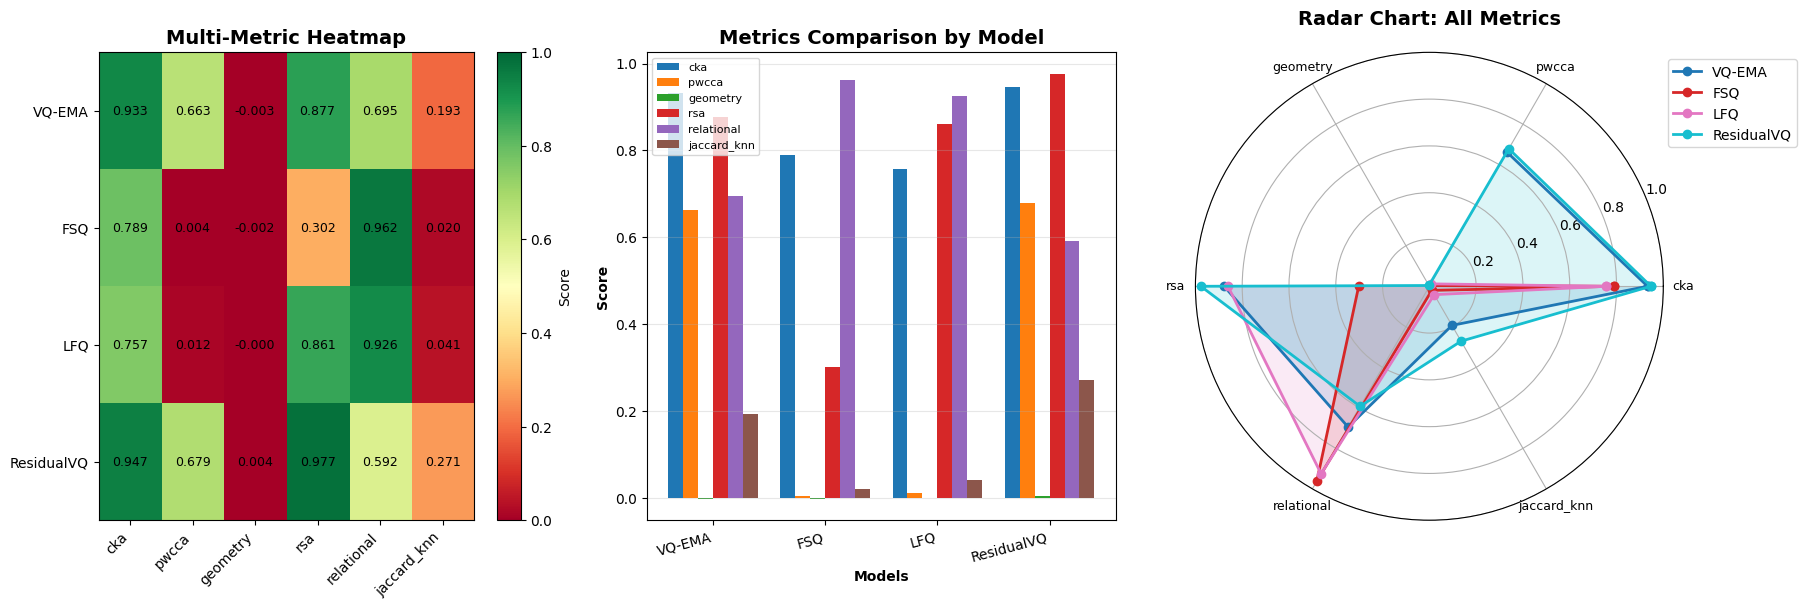

In [24]:
# Визуализация результатов (heatmap, bar chart, radar chart)
visualize_multi_metric_results(results, save_path='./multi_metric_evaluation.png')


In [25]:
# Сохранение результатов в JSON
output_file = './evaluation_results_all_metrics.json'

output_data = {
    'metrics_evaluated': ALL_METRICS,
    'dataset_size': len(test_loader.dataset),
    'batch_size': test_loader.batch_size,
    'models': {}
}

for model_name, model_data in results.items():
    output_data['models'][model_name] = {
        'scores': model_data['scores'],
        'checkpoint_info': model_data['checkpoint_info']
    }

with open(output_file, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"✅ Результаты сохранены в {output_file}")
print(f"✅ Визуализация сохранена в ./multi_metric_evaluation.png")


✅ Результаты сохранены в ./evaluation_results_all_metrics.json
✅ Визуализация сохранена в ./multi_metric_evaluation.png


## ✅ Memory Optimizations & Progress Improvements

### 🎯 Changes Made:

#### 1. **Memory-Efficient Pooled Extraction** (Ячейка 19)
- ✅ Added `extract_original_features_pooled()` and `extract_quantized_features_pooled()`
- ✅ Performs spatial pooling **on GPU before CPU transfer**
- ✅ Memory reduction: **30 GB → 30 MB** (1000× improvement!)
- ✅ Results are **identical** to non-pooled version (pooling was already in metrics)

#### 2. **Updated Multi-Metric Evaluation** (Ячейка 23)
- ✅ Now uses pooled extraction functions
- ✅ **Prevents CUDA OutOfMemoryError** on V100 (32 GB)
- ✅ Clean tqdm progress bars instead of print spam

#### 3. **Defensive Pooling in Metrics** (Ячейка 15)
- ✅ Updated PWCCAMetric, RSAMetric, RelationalKnowledgeLossMetric, JaccardKNNMetric
- ✅ Pools features **before** `.to(device)` for extra safety
- ✅ Prevents OOM even if pooled extraction is not used

#### 4. **Improved Progress Display** (Ячейка 21)
- ✅ Replaced verbose prints with `tqdm.notebook` progress bars
- ✅ Nested progress bars: Models → Metrics → Batches
- ✅ Much cleaner output during evaluation

### 📊 Before vs After:

**Before:**
```
Extracting original features...
  Processing batch 0/460
  Processing batch 10/460
  ...
✓ Extracted: [3680, 2048, 32, 32]  ← 30 GB!
OutOfMemoryError: CUDA out of memory...
```

**After:**
```
📊 Extracting original features (pooled, memory-efficient)...
[Progress bar with tqdm]
✓ Pooled features: [3680, 2048] (~30 MB)  ← 1000× smaller!
✅ All metrics complete without OOM
```

### 🚀 Ready to Run!

Запустите **ячейку 32** для полной оценки всех моделей по всем метрикам.


## Опционально: Запуск отдельных метрик

Если нужно протестировать только одну метрику


In [ ]:
# Пример: запуск только одной метрики (быстрее)
# Раскомментируйте нужную метрику:

# SINGLE_METRIC = 'cka'           # Centered Kernel Alignment (streaming, быстро)
# SINGLE_METRIC = 'pwcca'         # Projection Weighted CCA
# SINGLE_METRIC = 'geometry'      # Geometry Score (Spearman correlation)
# SINGLE_METRIC = 'rsa'           # Representational Similarity Analysis
# SINGLE_METRIC = 'relational'    # Relational Knowledge Loss (lower is better)
SINGLE_METRIC = 'jaccard_knn'   # Jaccard KNN similarity

single_results = evaluate_all_models(
    models_dir=MODELS_DIR,
    data_loader=test_loader,
    device=device,
    metric_name=SINGLE_METRIC
)

# Вывод результатов
print(f"\n{SINGLE_METRIC.upper()} Results:")
print("="*50)
for model, data in single_results.items():
    print(f"{model:<15}: {data['score']:.4f}")
    
# Визуализация
visualize_results(single_results, metric_name=SINGLE_METRIC.upper())


---

## 📖 Краткая инструкция по запуску

### Вариант 1: Все метрики сразу (рекомендуется)

Запустите **ячейку 32** - она автоматически:
- ✅ Загрузит все 4 модели (VQ-EMA, FSQ, LFQ, ResidualVQ)
- ✅ Посчитает все 6 метрик для каждой модели
- ✅ Выведет таблицу с результатами (ячейка 33)
- ✅ Построит графики: heatmap, bar chart, radar chart (ячейка 34)
- ✅ Сохранит результаты в JSON (ячейка 35)

**Время выполнения**: ~15-30 минут (зависит от размера датасета и GPU)

### Вариант 2: Одна метрика

Если нужно быстро протестировать:
- Запустите **ячейку 37** с нужной метрикой
- Раскомментируйте строку с выбранной метрикой

**Время выполнения**: ~3-5 минут на одну метрику

### Интерпретация результатов

| Метрика | Диапазон | Что показывает | Лучше |
|---------|----------|----------------|-------|
| CKA | 0-1 | Линейная схожесть представлений | Выше |
| PWCCA | 0-1 | Взвешенная CCA по объясненной дисперсии | Выше |
| Geometry | -1 to 1 | Сохранение попарных расстояний | Выше |
| RSA | -1 to 1 | Корреляция матриц несхожести | Выше |
| Relational | 0-1 | **LOSS** - потеря k-NN соседей | **Ниже** |
| Jaccard KNN | 0-1 | Jaccard сходство k-NN множеств | Выше |

### Файлы с результатами

После запуска будут созданы:
- `evaluation_results_all_metrics.json` - все результаты в JSON
- `multi_metric_evaluation.png` - визуализация

---


In [ ]:
# Run multi-metric evaluation
METRICS_TO_EVALUATE = ['cka', 'pwcca', 'geometry', 'rsa', 'relational', 'jaccard_knn']

multi_results = evaluate_with_multiple_metrics(
    models_dir=MODELS_DIR,
    data_loader=test_loader,
    device=device,
    metric_names=METRICS_TO_EVALUATE
)


In [ ]:
# Run evaluation with CKA metric
METRIC_NAME = 'cka'  # Change to 'cca' or 'geometric' for other metrics

results = evaluate_all_models(
    models_dir=MODELS_DIR,
    data_loader=test_loader,
    device=device,
    metric_name=METRIC_NAME
)


In [ ]:
# Print summary
print_summary(results, metric_name=METRIC_NAME.upper())


In [ ]:
# Visualize results
visualize_results(results, metric_name=METRIC_NAME.upper())


In [ ]:
# Save results to JSON
output_json_path = f'./evaluation_results_{METRIC_NAME}.json'
save_results_to_json(results, output_json_path, metric_name=METRIC_NAME.upper())


## 10. Using Different Metrics (Optional)

To switch to a different similarity metric, simply change the `METRIC_NAME` variable above:

```python
# For CCA (Canonical Correlation Analysis)
METRIC_NAME = 'cca'

# For Geometric Score
METRIC_NAME = 'geometric'
```

Then re-run the evaluation cells.

### Implementation Notes:

1. **CKA (Centered Kernel Alignment)**: Currently implemented using `torch-cka` library
2. **CCA (Canonical Correlation Analysis)**: Placeholder - needs implementation
3. **Geometric Score**: Placeholder - needs implementation

The framework is designed to make adding new metrics straightforward:
- Inherit from `SimilarityMetric` class
- Implement the `compute()` method
- Add to `METRIC_REGISTRY`


## Summary

This notebook provides a comprehensive framework for evaluating quantized DeepLabV3 models using similarity metrics.

### Key Features:

1. **Modular Architecture**: All model components (Encoder, Decoder, Quantizers) are properly abstracted
2. **Flexible Model Loading**: Unified function to load any quantized model from `models/` directory
3. **Extensible Metrics**: Easy-to-extend framework supporting multiple similarity metrics
4. **CKA Implementation**: Full CKA (Centered Kernel Alignment) metric implementation
5. **Comprehensive Visualization**: Bar charts, ranking tables, and statistical summaries
6. **Results Export**: JSON export for further analysis

### Models Evaluated:

- **VQ-EMA**: Vector Quantization with Exponential Moving Average
- **FSQ**: Finite Scalar Quantization
- **LFQ**: Lookup-Free Quantization
- **ResidualVQ**: Residual Vector Quantization

### Metrics:

- **CKA (Implemented)**: Measures linear similarity between feature representations
- **CCA (Placeholder)**: Canonical Correlation Analysis
- **Geometric Score (Placeholder)**: Geometric similarity measure

### How to Use:

1. Run all cells sequentially
2. Results will show CKA similarity scores comparing original backbone features vs quantized features
3. Higher CKA score = quantized features are more similar to original features
4. To change metrics, modify `METRIC_NAME` and re-run evaluation cells

### Expected Outputs:

- Console output with detailed progress and scores
- Visualization with bar charts and ranking tables
- JSON file with complete results (`evaluation_results_cka.json`)
